## organize data for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plot_helper import accuracy_plot, relation_plot
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19",
    ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

version = 'v20251216'
targets = ['SOCconc', 'CF', 'BD', 'SOCdensity']
models = ['UniNN','MultiNN','SiNN']

df = pd.read_parquet(f'./eval/all_cv.pred_with.lc_{version}.pq')


In [63]:

# read in
uni = pd.read_csv(f'./eval/mend_uniNN_cv.pred_{version}.csv')
print("UniNN:", uni.shape)
mlt = pd.read_csv(f'./eval/02_multiNN_cv.pred_{version}.csv')
print("MultiNN:", mlt.shape)
hbd = pd.read_csv(f'./eval/03_hybridNN_cv.pred_{version}.csv')
print("HybridNN:", hbd.shape)

# rename relevant cols
name_map = {"ndvi_glad_landast_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127":"ndvi",
            "ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218":"ndwi",
            "clm_lst_mod11a2_nighttime_p50_1km_s0_0cm_YYYY_v1_2":"lst_night",
            "clm_lst_mod11a2_daytime_p50_1km_s0_0cm_YYYY_v1_2":"lst_day",
            "clm_accum_precipitation_chelsa_annual_m_1km_s0_0cm_YYYY_v2_1":"precipitation",
            "peatland_extent_wri_gfw_peatgrids_p_1km_s_2000_2020_go_epsg4326_v20241017":"peat"}
mlt = mlt.rename(columns=name_map)

# get and rename pred cols
uni = uni[['row_id','pred_BD', 'pred_SOCconc','pred_CF', 'pred_SOCdensity']]
iid = models[0]
kmap = {}
for pp in ['pred_BD', 'pred_SOCconc', 'pred_CF', 'pred_SOCdensity']:
    kmap[pp] = pp.replace('pred',iid)
uni = uni.rename(columns=kmap)

mlt = mlt[['row_id', 'time', 'lat', 'lon', 'id', 'nuts0', 'maxdiff', 
       'bd','clay', 'sand', 'silt', 'cf', 'ocd', 'soc',
       'SOCconc', 'CF', 'BD', 'SOCdensity', 
       'pred_BD', 'pred_SOCconc', 'pred_CF', 'pred_SOCdensity', 
       'ndvi','ndwi','lst_night','lst_day','precipitation','peat']]
iid = models[1]
kmap = {}
for pp in ['pred_BD', 'pred_SOCconc', 'pred_CF', 'pred_SOCdensity']:
    kmap[pp] = pp.replace('pred',iid)
mlt = mlt.rename(columns=kmap)

hbd = hbd[['row_id','pred_BD', 'pred_SOCconc','pred_CF', 'pred_SOCdensity', 'pred_oBD', 'pred_mBD']]
iid = models[2]
kmap = {}
for pp in ['pred_BD', 'pred_SOCconc', 'pred_CF', 'pred_SOCdensity']:
    kmap[pp] = pp.replace('pred',iid)
hbd = hbd.rename(columns=kmap)


# join prediction results
df = mlt.merge(hbd, on="row_id", how="left")
df = df.merge(uni, on="row_id", how="left")
print(df.shape)

# ### get land cover
mm = []
for tt in ['2009','2012','2015','2018']:
    mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
    mmt['time'] = int(tt)
    mm.append(mmt[['POINT_ID', 'LC1', 'time']])
    
mm = pd.concat(mm)
mm['POINT_ID'] = pd.to_numeric(mm['POINT_ID'], errors='coerce')
mm = mm.dropna(subset=['POINT_ID'])
mm['POINT_ID'] = mm['POINT_ID'].astype(int)
mm = mm.rename(columns={'POINT_ID': 'id'})
merged = df.merge(mm, on=['id', 'time'], how='left')
merged['LC_group'] = merged['LC1'].str[0]  # Extract first letter

survey_dict = {
    "A": "artificial",
    "B": "cropland",
    "C": "woodland",
    "D": "shrubland",
    "E": "grassland",
    "F": "bareland", # bareland and lichen and mosses
    "G": "wetland", # water areas
    "H": "wetland",  # wetlands
}

# Map land cover codes to descriptions
merged['LC_group'] = merged['LC_group'].map(survey_dict)

print(merged.shape)
merged.to_parquet(f'./eval/all_cv.pred_with.lc_v20251216.pq')

UniNN: (56117, 389)
MultiNN: (56117, 389)
HybridNN: (56117, 391)
(56117, 38)


/tmp/ipykernel_41486/49534723.py:53: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
/tmp/ipykernel_41486/49534723.py:53: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
/tmp/ipykernel_41486/49534723.py:53: DtypeWarning: Columns (0,21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
/tmp/ipykernel_41486/49534723.py:53: DtypeWarning: Columns (0,32) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU

(56117, 40)


## accuracy analysis

/tmp/ipykernel_42626/3583875022.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


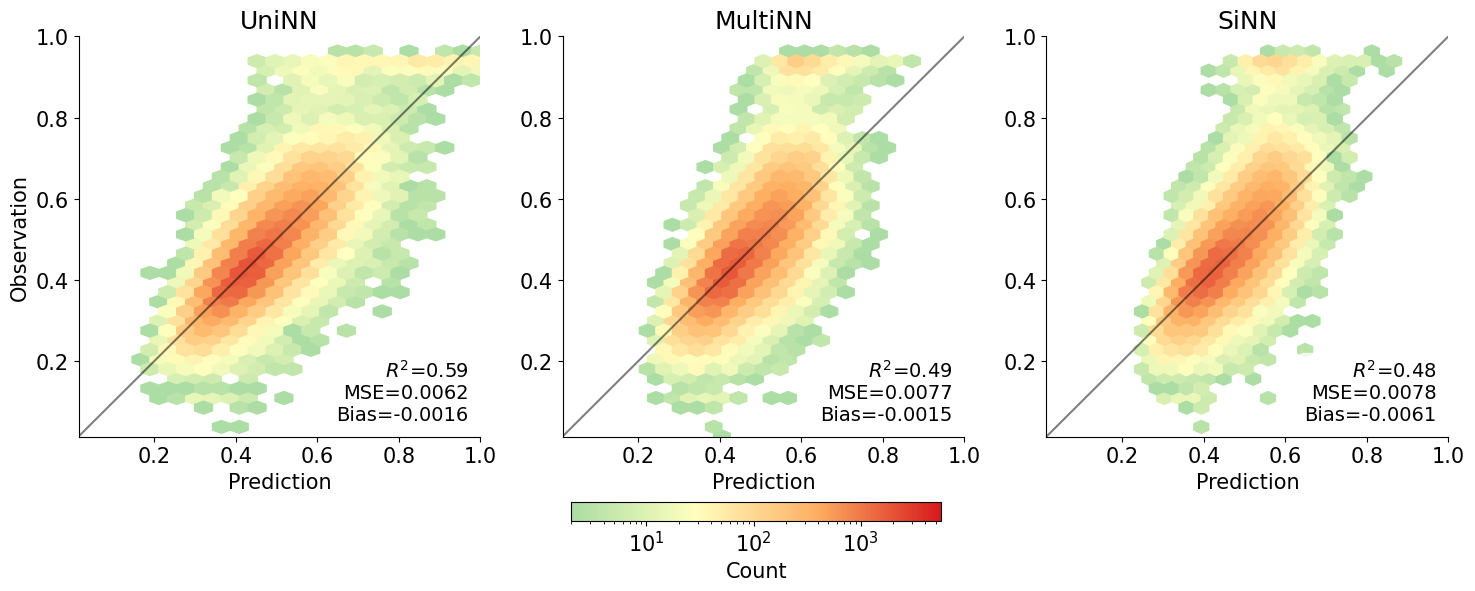

/tmp/ipykernel_42626/3583875022.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


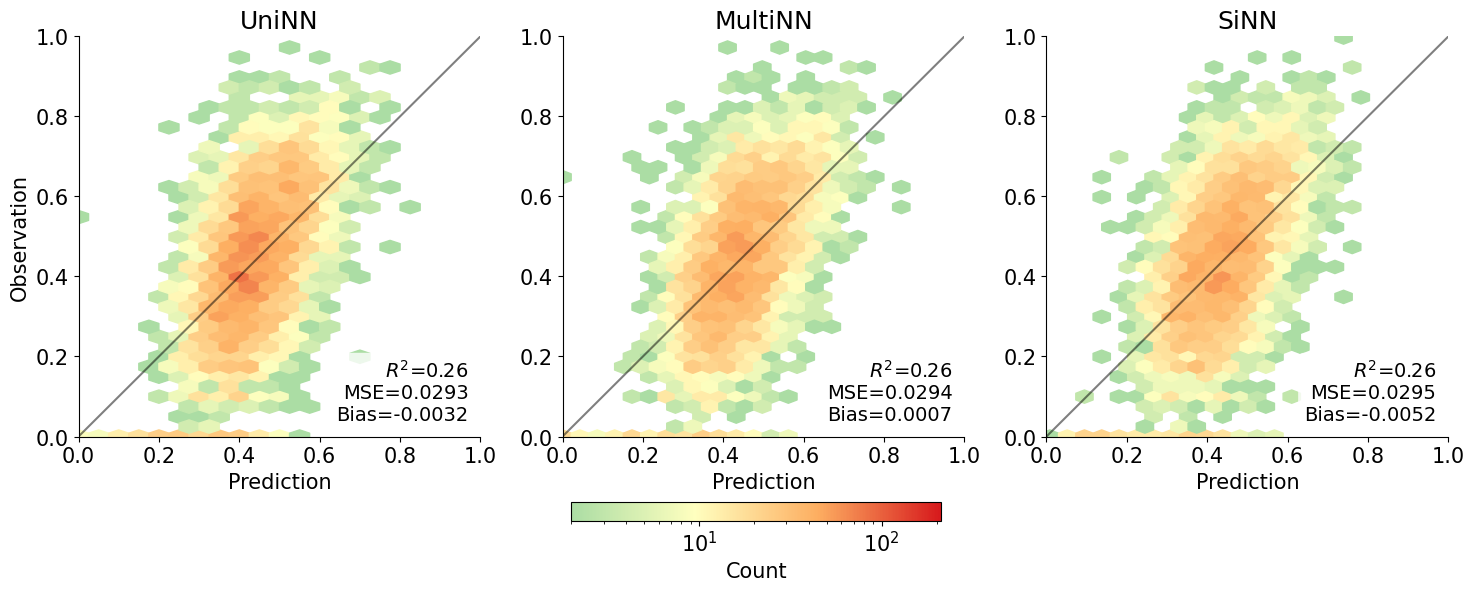

/tmp/ipykernel_42626/3583875022.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


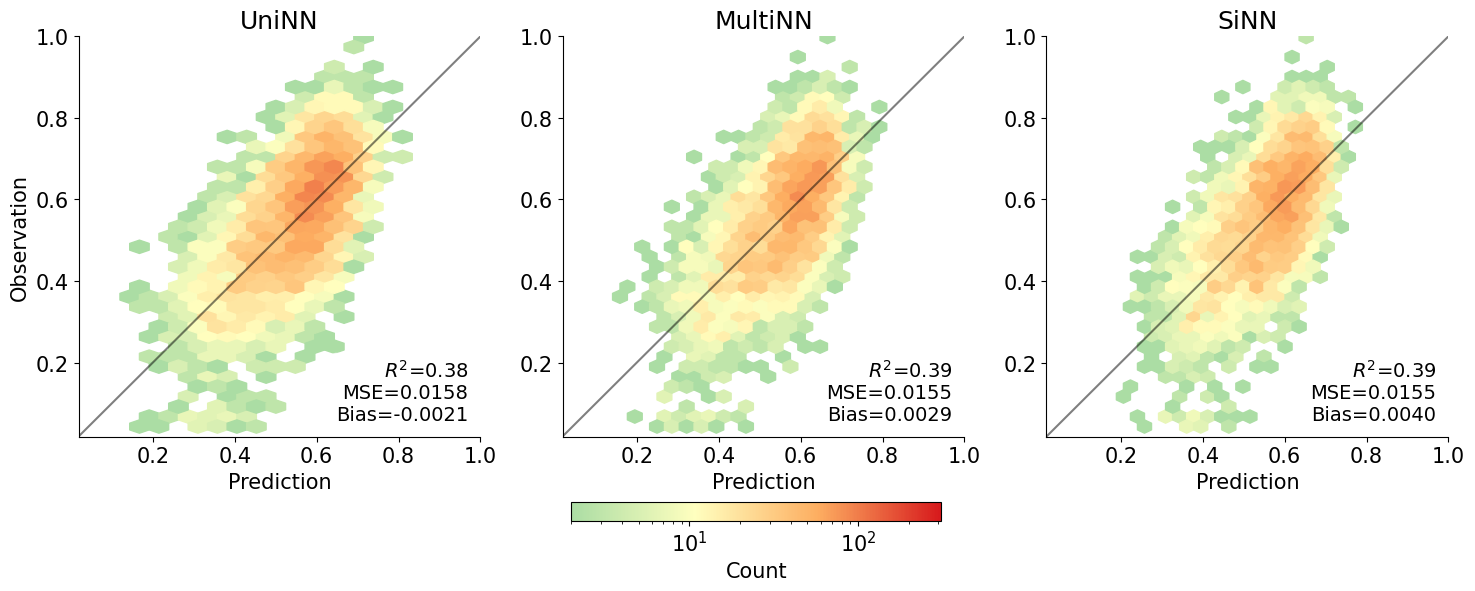

/tmp/ipykernel_42626/3583875022.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


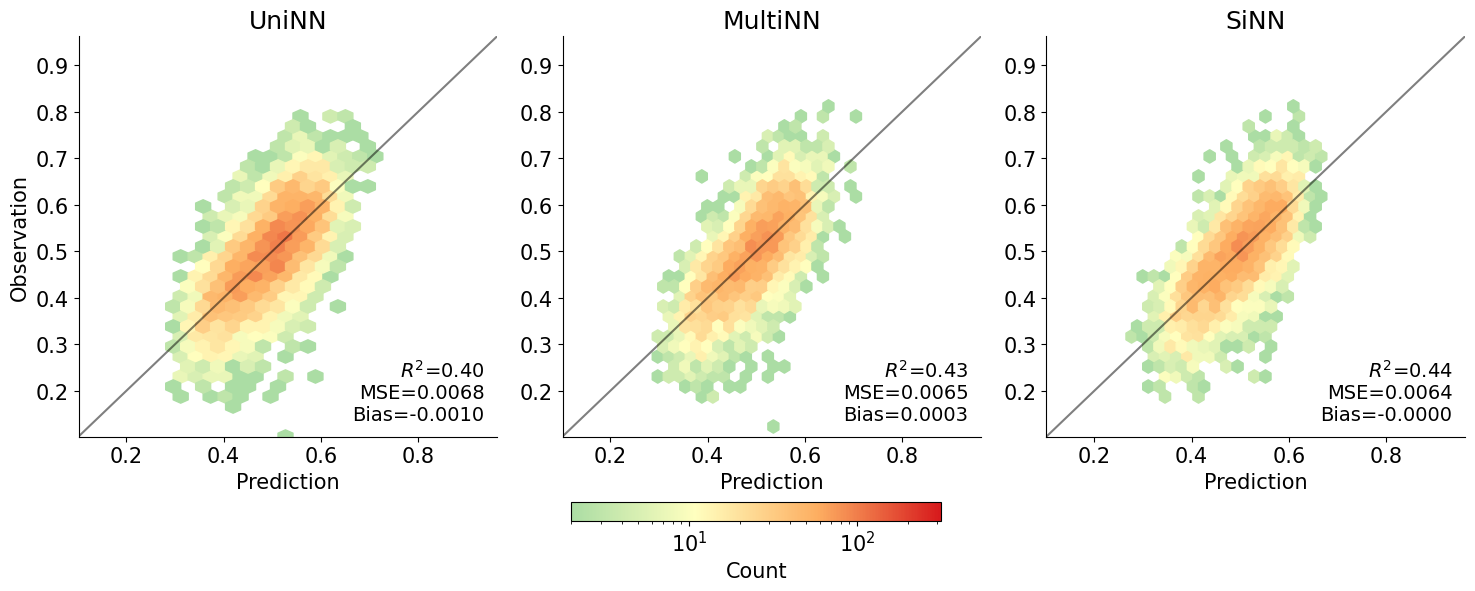

In [3]:


plt.rcParams.update({'font.size': 15})
gridsize = (20, 20)

def compute_r2_mse(y_true, y_pred):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_t = y_true[mask]
    y_p = y_pred[mask]
    if y_t.size == 0:
        return np.nan, np.nan
    mse = np.mean((y_t - y_p)**2)
    denom = np.sum((y_t - y_t.mean())**2)
    r2 = np.nan if denom == 0 else 1 - np.sum((y_t - y_p)**2) / denom
    bias = np.mean(y_p - y_t)
    return r2, mse, bias


for tgt in targets:

    # -------- Row-level normalization --------
    row_vals = []
    for mod in models:
        y_true = df[tgt].values
        y_pred = df[f"{mod}_{tgt}"].values
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        row_vals.append(np.column_stack([y_pred[mask], y_true[mask]]))

    row_vals = np.vstack(row_vals)
    vmin = row_vals.min()
    vmax = row_vals.max()

    dummy_fig, dummy_ax = plt.subplots()
    hb_ref = dummy_ax.hexbin(
        row_vals[:, 0], row_vals[:, 1],
        gridsize=gridsize, bins="log", mincnt=2
    )
    row_count_vmax = hb_ref.get_array().max()
    plt.close(dummy_fig)

    # -------- Create a figure for this target --------
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(models),
        figsize=(15, 6),
        sharex=False,
        sharey=False
    )

    if len(models) == 1:
        axes = [axes]

    hbs = []

    for j, mod in enumerate(models):
        ax = axes[j]
        y_true = df[tgt].values
        y_pred = df[f"{mod}_{tgt}"].values
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        y_t = y_true[mask]
        y_p = y_pred[mask]

        hb = ax.hexbin(
            y_p, y_t,
            gridsize=gridsize,
            cmap=cet_l19_cmap,
            bins="log",
            mincnt=2,
            vmax=row_count_vmax
        )
        hbs.append(hb)

        ax.plot([vmin, vmax], [vmin, vmax], "-k", alpha=0.5)
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)

        r2, mse, bias = compute_r2_mse(y_true, y_pred)
        ax.set_title(f"{mod}")
        ax.text(
            0.97, 0.03,
            f"$R^2$={r2:.2f}\nMSE={mse:.4f}\nBias={bias:.4f}",
            transform=ax.transAxes,
            ha="right",
            va="bottom",
            fontsize=14,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8)
        )
        ax.set_xlabel("Prediction")
        if j == 0:
            ax.set_ylabel("Observation")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # -------- Shared colorbar placed lower --------
    # Increase pad, reduce fraction to keep it compact
    cbar = fig.colorbar(
        hbs[0], ax=axes,
        location="bottom",
        fraction=0.04,      # smaller bar height
        pad=0.35            # move colorbar further below plots
    )
    cbar.set_label("Count")

    # Ensure subplots don't get squeezed into the colorbar
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.25)   # extra bottom margin so bar is safely below plots
    fig.savefig(f"./fig/accuracy_{tgt}.pdf", bbox_inches="tight")

    plt.show()


In [16]:
# by land covers
rows = []

for lc in sorted(df["LC_group"].dropna().unique()):
    df_lc = df[df["LC_group"] == lc]

    for mod in models:
        y_true = df_lc["SOCdensity"].values
        y_pred = df_lc[f"{mod}_SOCdensity"].values

        r2, mse, bias = compute_r2_mse(y_true, y_pred)

        rows.append({
            "LC_group": lc,
            "model": mod,
            "R2": r2,
            "MSE": mse,
            "Bias": bias,
            "n": np.isfinite(y_true).sum()
        })

df_lc_metrics = pd.DataFrame(rows)
df_lc_metrics

,LC_group,model,R2,MSE,Bias,n
0,artificial,UniNN,0.297581,0.009383,0.002479,24
1,artificial,MultiNN,0.263262,0.009841,-0.008586,24
2,artificial,SiNN,0.176418,0.011001,-0.006553,24
3,bareland,UniNN,0.447549,0.005668,0.014894,203
4,bareland,MultiNN,0.436303,0.005783,0.013756,203
5,bareland,SiNN,0.435611,0.005790,0.016409,203
6,cropland,UniNN,0.399379,0.005002,0.006973,2339
7,cropland,MultiNN,0.413151,0.004888,0.003416,2339
8,cropland,SiNN,0.413156,0.004888,0.003340,2339
9,grassland,UniNN,0.388932,0.006820,-0.003276,1159


## joint distribution between BD and SOCconc

In [4]:

scalers = {
    "SOCconc": 0.151,
    "CF": 0.263,
    "BD": 0.529,
    "SOCdensity": 0.167
}

for mod in models:
    df[f"{mod}_soc"] = np.exp(df[f"{mod}_SOCconc"] / scalers["SOCconc"]) - 1
    df[f"{mod}_cf"]  = np.exp(df[f"{mod}_CF"] / scalers["CF"]) - 1
    df[f"{mod}_bd"]  = df[f"{mod}_BD"] / scalers["BD"]
    df[f"{mod}_ocd"] = np.exp(df[f"{mod}_SOCdensity"] / scalers["SOCdensity"])


/tmp/ipykernel_42626/4023731183.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


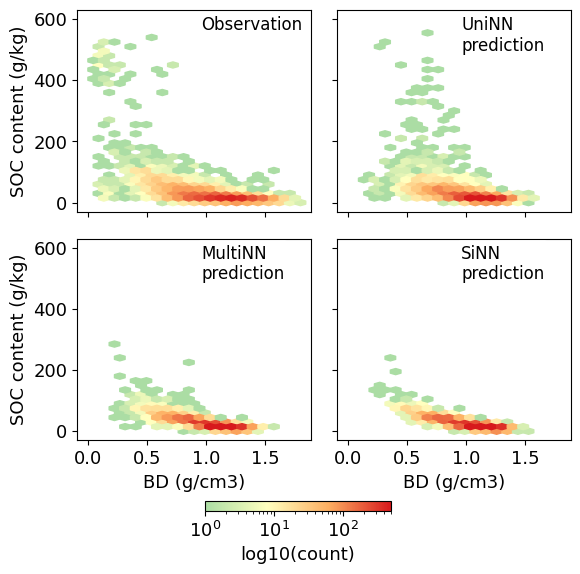

In [5]:
dff = df.copy()
dff = dff.dropna(subset=["bd"])
ext = (0, 1.8, 0, 600)
mcnt = 1

row_count_vmax = 500
gridsize = (20, 20)
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
axes = axes.ravel()

# --- 1. Observations ---
hb0 = axes[0].hexbin(
    dff['bd'], dff['soc'],
    gridsize=gridsize,
    cmap=cet_l19_cmap,
    bins="log",
    mincnt=mcnt,
    extent = ext,
    vmax=row_count_vmax
)
# axes[0].set_title("Observations")
axes[0].set_xlabel("BD (g/cm3)")
axes[0].set_ylabel("SOC content (g/kg)")

# --- 2. MultiNN Predictions ---
hb1 = axes[1].hexbin(
    dff['UniNN_bd'], dff['UniNN_soc'],
    gridsize=gridsize,
    cmap=cet_l19_cmap,
    bins="log",
    mincnt=mcnt,
    extent = ext,
    vmax=row_count_vmax
)
# axes[1].set_title("UniNN Prediction")
axes[1].set_xlabel("BD (g/cm3)")
axes[1].set_ylabel("SOC content (g/kg)")

# --- 3. SiNN Predictions ---
hb2 = axes[2].hexbin(
    dff['MultiNN_bd'], dff['MultiNN_soc'],
    gridsize=gridsize,
    cmap=cet_l19_cmap,
    bins="log",
    mincnt=mcnt,
    extent = ext,
    vmax=row_count_vmax
)
# axes[2].set_title("MultiNN Prediction")
axes[2].set_xlabel("BD (g/cm3)")
axes[2].set_ylabel("SOC content (g/kg)")

# --- 4. 任意你需要的第四幅图（添加你自己的变量） ---
hb3 = axes[3].hexbin(
    dff['SiNN_bd'], dff['SiNN_soc'],     # 用你的真实变量名替换
    gridsize=gridsize,
    cmap=cet_l19_cmap,
    bins="log",
    mincnt=mcnt,
    extent = ext,
    vmax=row_count_vmax
)
# axes[3].set_title("SiNN Prediction")
axes[3].set_xlabel("BD (g/cm3)")
axes[3].set_ylabel("SOC content (g/kg)")

# text
labels = [
    "Observation",
    "UniNN\nprediction",
    "MultiNN\nprediction",
    "SiNN\nprediction"
]

for ax, label in zip(axes, labels):
    ax.text(
        0.53, 0.97, label,
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8)
    )
    
for ax in axes:
    ax.label_outer()
    
# --- Bottom shared colorbar ---
cbar = fig.colorbar(
    hb3, 
    ax=axes,
    orientation="horizontal",
    fraction=0.05,
    pad=0.2,     # 调整 pad 让 colorbar 更靠下，避免和图重叠
    shrink=0.4
)
cbar.set_label("log10(count)")

fig.tight_layout()
fig.subplots_adjust(bottom=0.25)   # 确保 colorbar 不与图重叠
# fig.savefig(f"./fig/joint_distribution.pdf", bbox_inches="tight")
plt.show()


## temporal stability of the prediction

In [7]:

df_filtered = df.copy()

# Columns to analyse
vars_to_check = ["UniNN_ocd", "MultiNN_ocd", "SiNN_ocd"]

# ---- 1. COUNT IDS BY NUMBER OF TIME POINTS ----
id_counts = df_filtered['id'].value_counts()

num_ids_all3 = (id_counts == 3).sum()
num_ids_not3 = (id_counts != 3).sum()

print("IDs with all 3 time points:", num_ids_all3)
print("IDs WITHOUT all 3 time points:", num_ids_not3)

# ---- 2. KEEP ONLY IDS THAT HAVE ALL 3 ROWS ----
valid_ids = id_counts[id_counts == 3].index
df3 = df_filtered[df_filtered['id'].isin(valid_ids)]

print("Filtered dataframe shape:", df3.shape)

# ---- 3. TEMPORAL STABILITY USING IQR AND RANGE ----
stability = (
    df3.groupby("id")[vars_to_check]
       .agg(['min', 'max', lambda x: np.nanmin(x) - np.nanmax(x)])
)

# rename columns
stability.columns = [f"{var}_{stat}"
                     for var, stat in stability.columns]
stability = stability.reset_index()

# Compute range
for var in vars_to_check:
    stability[f"{var}_range"] = stability[f"{var}_max"] - stability[f"{var}_min"]



IDs with all 3 time points: 11690
IDs WITHOUT all 3 time points: 13738
Filtered dataframe shape: (35070, 52)


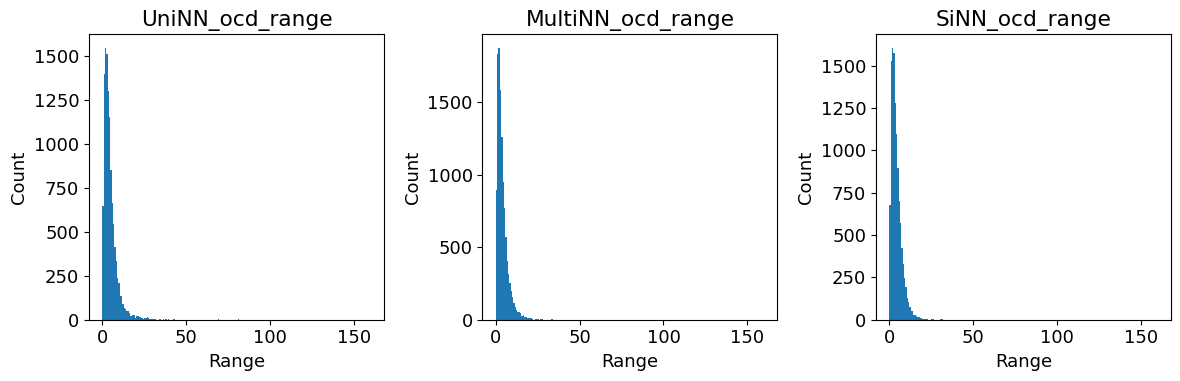

In [14]:

# Corresponding range columns
range_cols = [f"{v}_range" for v in vars_to_check]

plt.figure(figsize=(12, 4))

for i, col in enumerate(range_cols):
    plt.subplot(1, 3, i+1)
    plt.hist(stability[col].dropna(), bins=200, range=[0,160])
    plt.title(col)
    plt.xlabel("Range")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


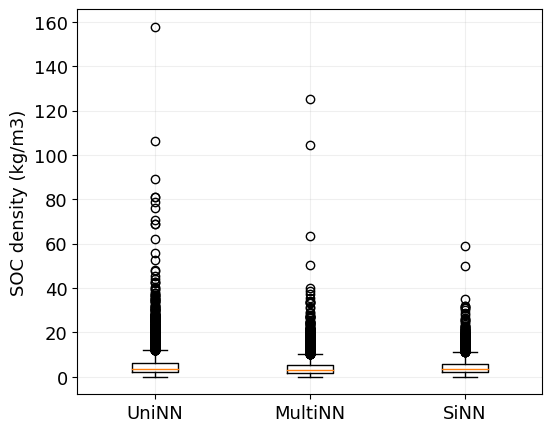

In [17]:
plt.figure(figsize=(6,5))
val_labels = ["UniNN","MultiNN","SiNN"]
plt.boxplot(
    [stability[f"{v}_range"].dropna() for v in vars_to_check],
    labels=val_labels,
    showfliers=True
)

plt.ylabel("SOC density (kg/m3)")
# plt.ylim([0,1])
# plt.title("Range Distribution Across Variables")
plt.grid(alpha=0.2)
plt.savefig(f"./fig/temporal_plausibility.pdf", bbox_inches="tight")
plt.show()


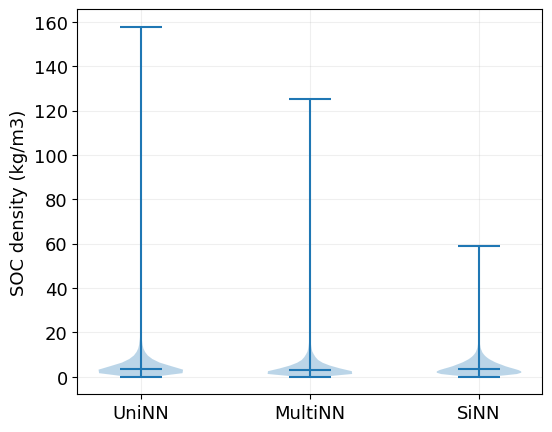

In [15]:
plt.figure(figsize=(6,5))

val_labels = ["UniNN", "MultiNN", "SiNN"]
data = [stability[f"{v}_range"].dropna() for v in vars_to_check]

vp = plt.violinplot(
    data,
    showmeans=False,
    showmedians=True,
    showextrema=True
)

# 设置 x 轴刻度标签
plt.xticks(range(1, len(val_labels) + 1), val_labels)

plt.ylabel("SOC density (kg/m3)")
plt.grid(alpha=0.2)

# plt.savefig("./fig/temporal_plausibility_violin.pdf", bbox_inches="tight")
plt.show()


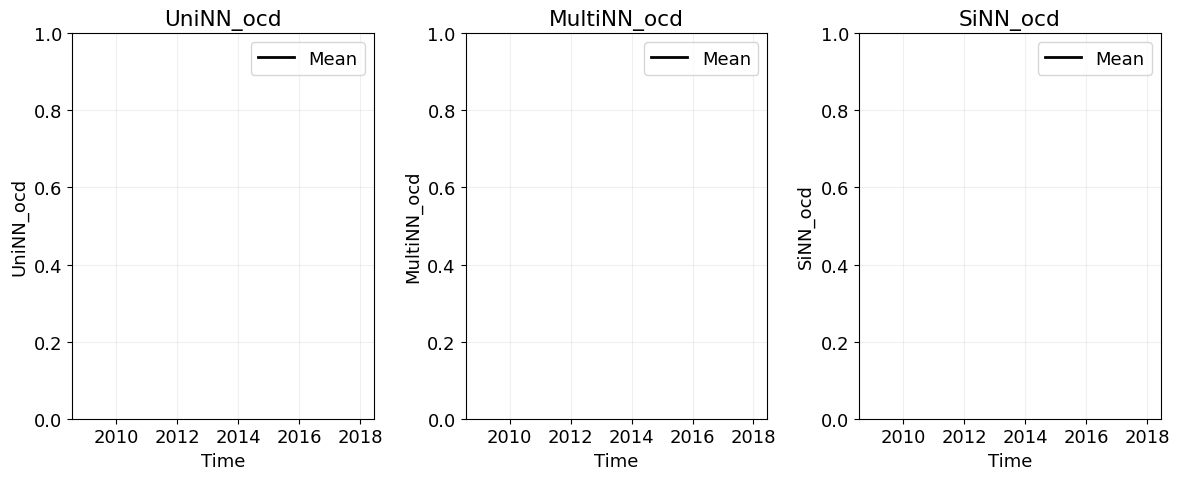

In [13]:
plt.figure(figsize=(12,5))

for idx, var in enumerate(vars_to_check, 1):

    plt.subplot(1, 3, idx)

    # --- plot all individual time series ---
    for gid, gdf in df3.groupby("id"):
        gdf_sorted = gdf.sort_values("time")
        plt.plot(gdf_sorted["time"], gdf_sorted[var],
                 color="gray", alpha=0.25, linewidth=1)

    # --- compute mean and plot ---
    mean_df = df3.groupby("time")[var].mean().reset_index()
    plt.plot(mean_df["time"], mean_df[var],
             color="black", linewidth=2, label="Mean")

    plt.title(var)
    plt.xlabel("Time")
    plt.ylabel(var)
    plt.ylim([0,1])
    plt.grid(True, alpha=0.2)
    plt.legend()

plt.tight_layout()
plt.show()


UniNN
SOCdensity 5194 5194


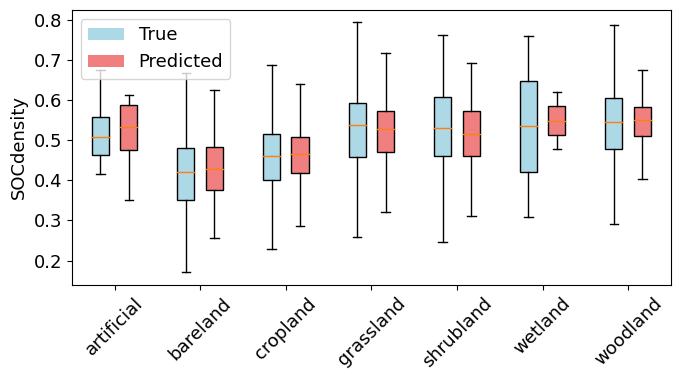

MultiNN
SOCdensity 5194 56117


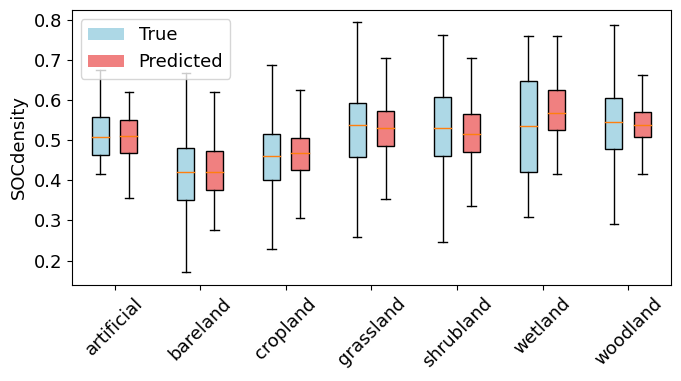

SiNN
SOCdensity 5194 56117


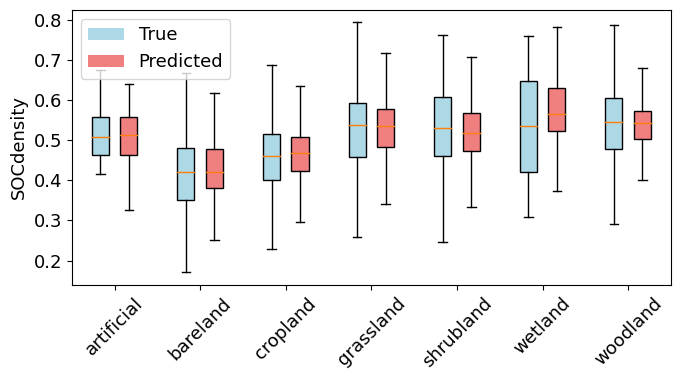

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


target_names = ['SOCconc', 'CF', 'BD', 'SOCdensity']
land_covers = sorted([x for x in df['LC_group'].dropna().unique() if isinstance(x, str)])

colors = ['lightblue', 'lightcoral']  # True vs Pred colors
legend_labels = ['True', 'Predicted']
target = "SOCdensity"
for mod in models:
    print(mod)
    pred_col = f'{mod}_SOCdensity'
    print(target, df[target].notna().sum(), df[pred_col].notna().sum())
    
    plt.figure(figsize=(7, 4))
    
    positions = []
    data = []
    
    for i, lc in enumerate(land_covers):
        group = df[df['LC_group'] == lc]
        data.append(group[target].dropna())
        data.append(group[pred_col].dropna())
        
        # Position true at i*3 + 1, pred at i*3 + 2
        positions += [i * 3 + 1, i * 3 + 2]
    
    bp = plt.boxplot(data, positions=positions, widths=0.6, showfliers=False, patch_artist=True)
    
    # Color the boxes
    for j, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[j % 2])  # Alternate colors for true/pred
    
    # X-axis ticks: one per land cover
    x_tick_positions = [i * 3 + 1.5 for i in range(len(land_covers))]
    plt.xticks(x_tick_positions, land_covers, rotation=45)
    
    # plt.title(f'{target}: True vs Predicted by Land Cover')
    plt.ylabel(target)
    plt.xlim(0, len(land_covers) * 3)
    
    # Add legend
    legend_patches = [Patch(facecolor=colors[i], label=legend_labels[i]) for i in range(2)]
    plt.legend(handles=legend_patches)
    
    plt.tight_layout()
    plt.show()



## plausibility check: oBD and mBD

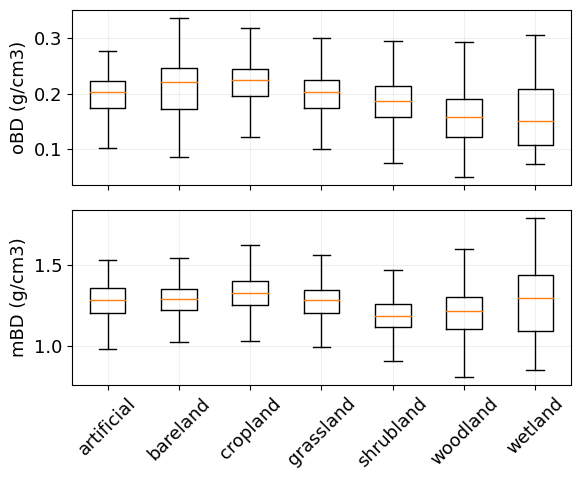

In [73]:
import matplotlib.pyplot as plt
land_covers = [
    "artificial",
    "bareland",
    "cropland",
    "grassland",
    "shrubland",
    "woodland",
    "wetland"
]
targets = ["pred_oBD", "pred_mBD"]
ylabels = ["oBD (g/cm3)","mBD (g/cm3)"]
# titles = ["Latent organic bulk density (oBD)",
          # "Latent mineral bulk density (mBD)"]

fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

for ax, target, ylabel in zip(axes, targets, ylabels):
    data = [
        df[df["LC_group"] == lc][target].dropna()
        for lc in land_covers
    ]

    ax.boxplot(
        data,
        labels=land_covers,
        showfliers=False
    )
    # ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.2)

axes[-1].set_xticks(range(1, len(land_covers) + 1))
axes[-1].set_xticklabels(land_covers, rotation=45)

fig.tight_layout()
fig.savefig(f"./fig/latent_land.cover.pdf", bbox_inches="tight")
plt.show()


<Axes: >

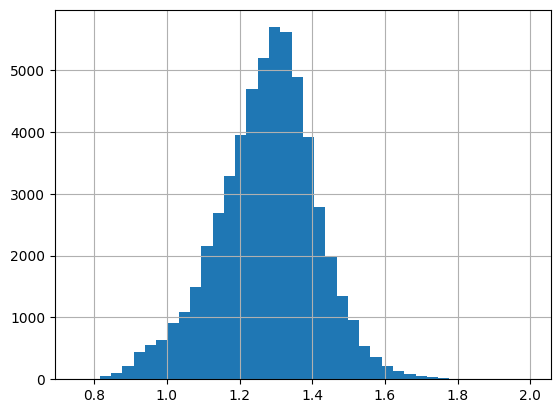

In [15]:
df['pred_mBD'].hist(bins=40)

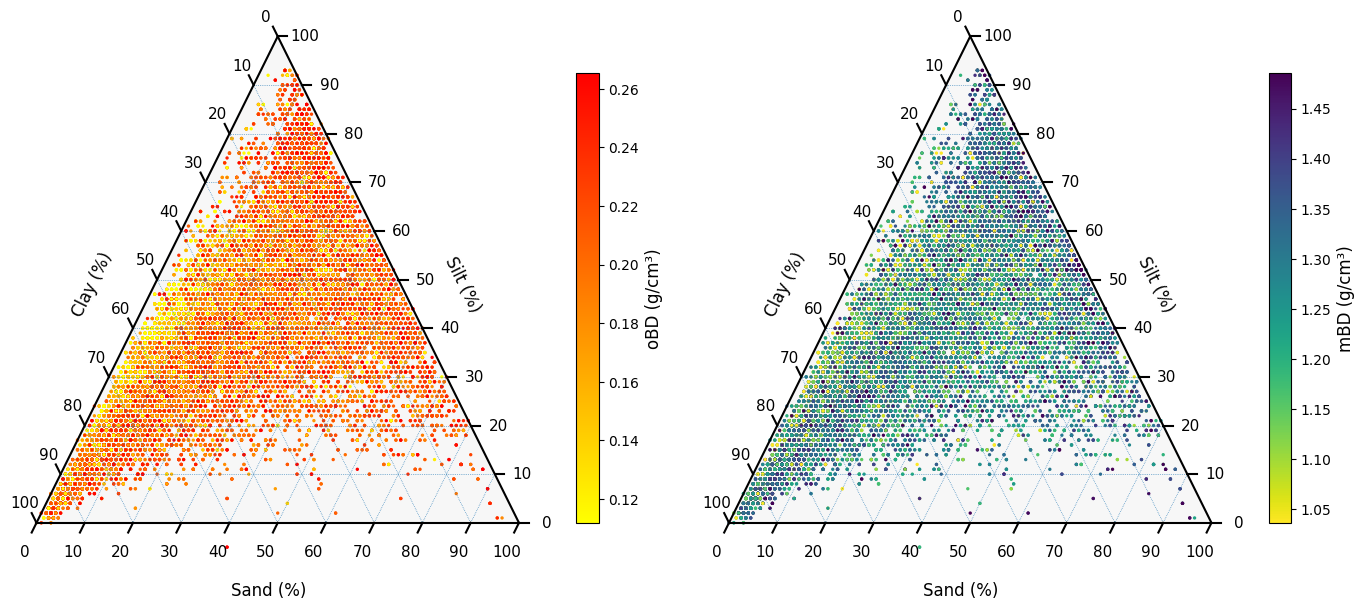

In [39]:
import ternary
import matplotlib as mpl

df_filter = df.loc[(df['clay'] + df['silt'] + df['sand']) == 100]
points = df_filter[['clay', 'silt', 'sand']].values

colors_oBD = df_filter['pred_oBD'].values
colors_mBD = df_filter['pred_mBD'].values

vmin_o = np.quantile(colors_oBD, 0.05)
vmax_o = np.quantile(colors_oBD, 0.95)

vmin_m = np.quantile(colors_mBD, 0.05)
vmax_m = np.quantile(colors_mBD, 0.95)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
tax_o = ternary.TernaryAxesSubplot(ax=axes[0], scale=100)

tax_o.scatter(
    points,
    c=colors_oBD,
    cmap='autumn_r',
    vmin=vmin_o,
    vmax=vmax_o,
    s=2
)

tax_o.left_axis_label("Clay (%)",  offset=0.14, fontsize=12)
tax_o.right_axis_label("Silt (%)", offset=0.14, fontsize=12)
tax_o.bottom_axis_label("Sand (%)", offset=0.07, fontsize=12)

tax_o.gridlines(multiple=10)
tax_o.ticks(
    axis='lbr',
    multiple=10,
    fontsize=11,
    offset=0.02
)

tax_o.boundary()
tax_o.clear_matplotlib_ticks()
tax_o.get_axes().axis('off')

# colorbar (oBD)
sm_o = mpl.cm.ScalarMappable(
    cmap='autumn_r',
    norm=mpl.colors.Normalize(vmin=vmin_o, vmax=vmax_o)
)
sm_o.set_array([])

cbar_o = plt.colorbar(sm_o, ax=axes[0], shrink=0.8)
cbar_o.set_label("oBD (g/cm³)", fontsize=12)
tax_m = ternary.TernaryAxesSubplot(ax=axes[1], scale=100)

tax_m.scatter(
    points,
    c=colors_mBD,
    cmap='viridis_r',
    vmin=vmin_m,
    vmax=vmax_m,
    s=2
)

tax_m.left_axis_label("Clay (%)",  offset=0.14, fontsize=12)
tax_m.right_axis_label("Silt (%)", offset=0.14, fontsize=12)
tax_m.bottom_axis_label("Sand (%)", offset=0.07, fontsize=12)

tax_m.gridlines(multiple=10)
tax_m.ticks(
    axis='lbr',
    multiple=10,
    fontsize=11,
    offset=0.02
)

tax_m.boundary()
tax_m.clear_matplotlib_ticks()
tax_m.get_axes().axis('off')

# colorbar (mBD)
sm_m = mpl.cm.ScalarMappable(
    cmap='viridis_r',
    norm=mpl.colors.Normalize(vmin=vmin_m, vmax=vmax_m)
)
sm_m.set_array([])

cbar_m = plt.colorbar(sm_m, ax=axes[1], shrink=0.8)
cbar_m.set_label("mBD (g/cm³)", fontsize=12)
plt.tight_layout()
fig.savefig(f"./fig/latent_texture.pdf", bbox_inches="tight")
plt.show()


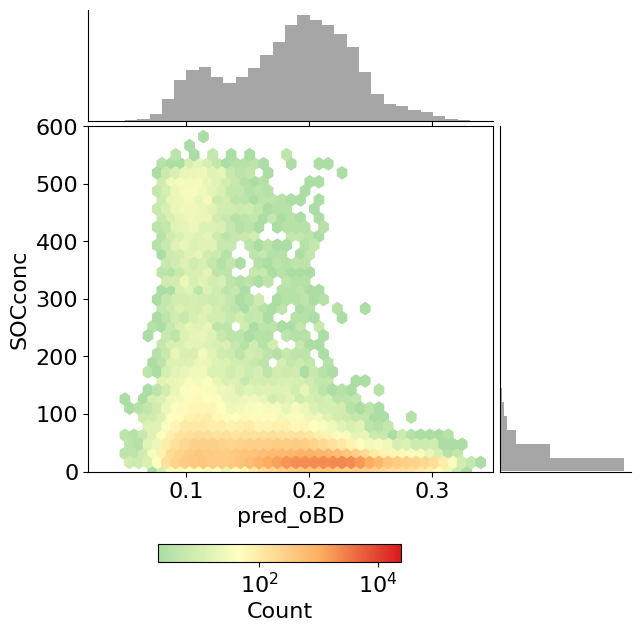

In [14]:
x = df['pred_oBD'] #/ scalers.get('BD')
y = df['SOCconc'] #/ scalers.get('SOCconc')
relation_plot(x, y,'pred_oBD', 'SOCconc', [0.02,0.35], [0,600], save_plot=False)

### temporal SOC realism
- Less fluctuations in SOCdensity predictions?
- Train model on lucas2018, whether hybrid performs better in predicting lucas2009 & 2015